## Compare LightGBM in the case of binary class (Sell, Buy)

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_lightgbm,
    select_threshold,
)

In [2]:
METRIC = "precision"
TEST_SIZE = 300
FPR_MAX = 0.05
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline LightGBM Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [9]:
# orig_df["r"] = interest_rate

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [11]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 20:05:10,602] A new study created in memory with name: no-name-36e6fa96-d8e2-4386-8f5f-edaab7d1eff7
[I 2024-02-14 20:05:12,545] Trial 0 finished with value: 0.6535222345261466 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'feature_fraction': 0.5157500776564684, 'bagging_fraction': 0.9559495145396355, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 0 with value: 0.6535222345261466.
[I 2024-02-14 20:05:13,281] Trial 1 finished with value: 0.6428439485234821 and parameters: {'lambda_l1': 4.4622527237644664e-05, 'lambda_l2': 0.001522988392116389, 'num_leaves': 243, 'feature_fraction': 0.4941731326532077, 'bagging_fraction': 0.9532107188094674, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 0 with value: 0.6535222345261466.
[I 2024-02-14 20:05:13,583] Trial 2 finished with value: 0.5818061623896699 and parameters: {'lambda_l1': 0.9174571299820613, 'lambda_l2': 7.370748490098066, 'num_leaves': 

Number of finished trials: 150
Best trial:
  Value: 0.66880994256037
  Params: 
    lambda_l1: 4.1342972795431155e-05
    lambda_l2: 1.8274447801521803
    num_leaves: 219
    feature_fraction: 0.9858923882998724
    bagging_fraction: 0.925196810349399
    bagging_freq: 1
    min_child_samples: 10


In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **trial.params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [13]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.925196810349399,
                                bagging_freq=1,
                                feature_fraction=0.9858923882998724,
                                lambda_l1=4.1342972795431155e-05,
                                lambda_l2=1.8274447801521803,
                                metric='average_precision',
                                min_child_samples=10, num_leaves=219,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [14]:
# In-sample score
pipe.score(X_train, y_train)

0.9991319444444444

In [15]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.54


In [16]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [17]:
pipe.score(X_test, y_test)

0.5066666666666667

              precision    recall  f1-score   support

           0       0.65      0.30      0.41       170
           1       0.46      0.78      0.58       130

    accuracy                           0.51       300
   macro avg       0.55      0.54      0.50       300
weighted avg       0.57      0.51      0.48       300



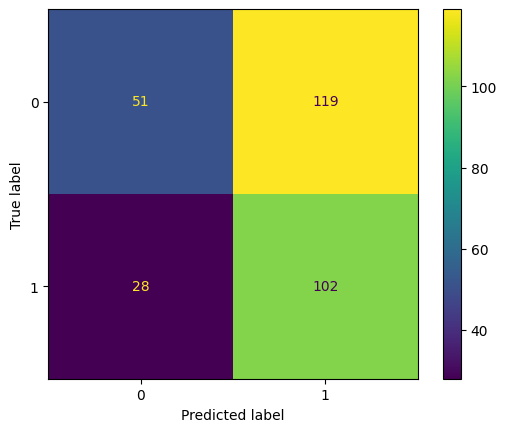

In [18]:
display_report(y_test, predictions)

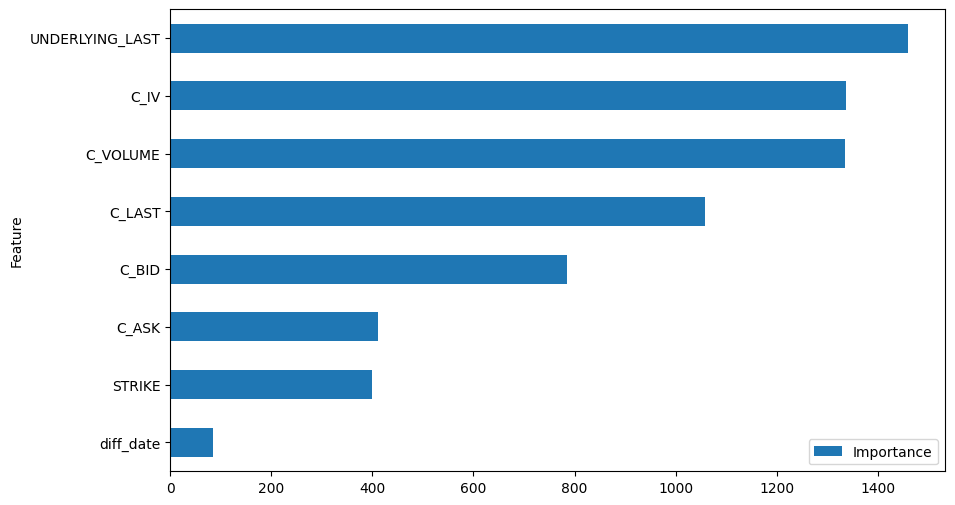

In [19]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [20]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [21]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [22]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,1,414.0,7.58,2022-08-24,413.670013,-7.58,-7.580000,-7.580000,-7.580000
2022-08-05,1,413.0,7.66,2022-08-26,405.309998,-7.66,-7.660000,-15.240000,-15.240000
2022-08-08,1,413.0,7.44,2022-08-29,402.630005,-7.44,-7.440000,-22.680000,-22.680000
2022-08-09,1,411.0,7.51,2022-08-29,402.630005,-7.51,-7.510000,-30.190000,-30.190000
2022-08-10,1,420.0,6.90,2022-08-31,395.179993,-6.90,-6.900000,-37.090000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.00,-2.390007,154.099976,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.00,-3.020007,154.099976,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.00,0.239993,154.099976,126.819912


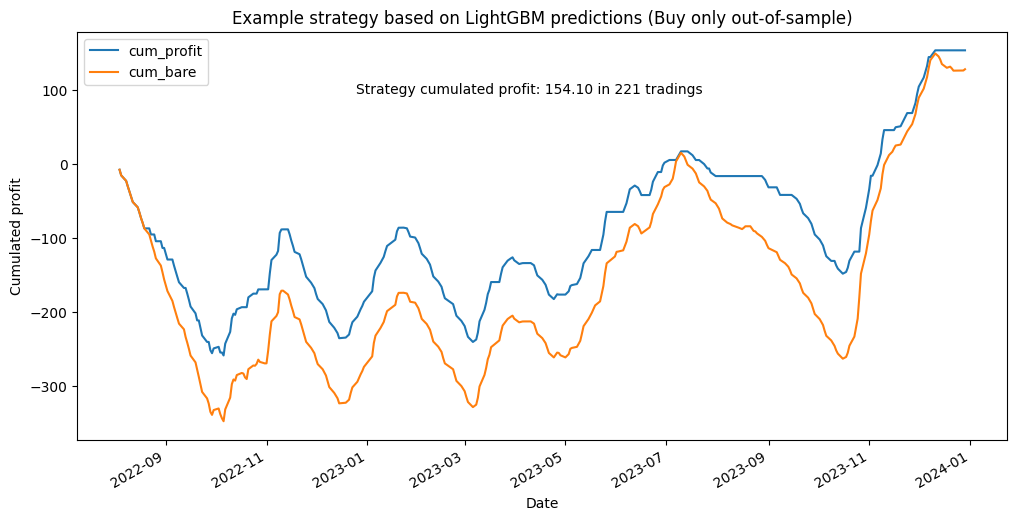

In [23]:
plot_strategy(strategy_df, "LightGBM", "(Buy only out-of-sample)")

In [24]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## LightGBM with data from MC simulation and additional features

In [25]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [26]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [28]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT * 2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 20:08:19,709] A new study created in memory with name: no-name-fd38fd23-6406-4a58-b5d4-93526b33801c


[I 2024-02-14 20:08:21,809] Trial 0 finished with value: 0.690189268473464 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'feature_fraction': 0.5157500776564684, 'bagging_fraction': 0.9559495145396355, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 0 with value: 0.690189268473464.
[I 2024-02-14 20:08:22,921] Trial 1 finished with value: 0.6950996317389748 and parameters: {'lambda_l1': 4.4622527237644664e-05, 'lambda_l2': 0.001522988392116389, 'num_leaves': 243, 'feature_fraction': 0.4941731326532077, 'bagging_fraction': 0.9532107188094674, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 1 with value: 0.6950996317389748.
[I 2024-02-14 20:08:23,899] Trial 2 finished with value: 0.6913436197515256 and parameters: {'lambda_l1': 3.935812964529853e-08, 'lambda_l2': 6.940568812421573e-08, 'num_leaves': 21, 'feature_fraction': 0.4213752158570198, 'bagging_fraction': 0.8894514372980655, 'bagging_freq': 2, 'min_c

Number of finished trials: 150
Best trial:
  Value: 0.7255361686970839
  Params: 
    lambda_l1: 1.9778869988232345e-06
    lambda_l2: 1.6078475758773735e-07
    num_leaves: 227
    feature_fraction: 0.6103578367044774
    bagging_fraction: 0.8474595124557138
    bagging_freq: 7
    min_child_samples: 10


In [29]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **study.best_params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [30]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.8474595124557138,
                                bagging_freq=7,
                                feature_fraction=0.6103578367044774,
                                lambda_l1=1.9778869988232345e-06,
                                lambda_l2=1.6078475758773735e-07,
                                metric='average_precision',
                                min_child_samples=10, num_leaves=227,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [31]:
# In-sample score
pipe.score(X_train, y_train)

1.0

In [32]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.94


In [33]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [34]:
pipe.score(X_test, y_test)

0.4766666666666667

              precision    recall  f1-score   support

           0       0.61      0.73      0.66       170
           1       0.52      0.38      0.44       130

    accuracy                           0.58       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.57      0.58      0.57       300



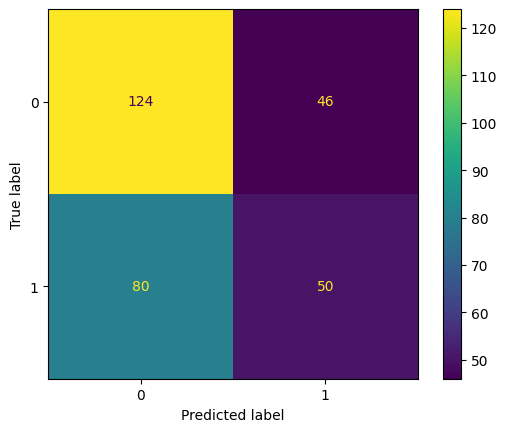

In [35]:
display_report(y_test, predictions)

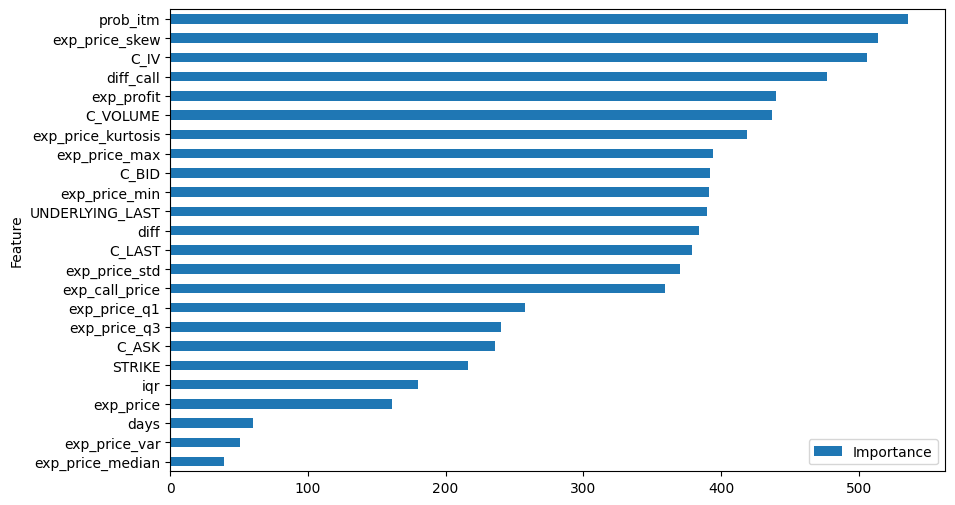

In [36]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [37]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [38]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [39]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.0,-7.580000,0.000000,-7.580000
2022-08-05,0,413.0,7.66,2022-08-26,405.309998,0.0,-7.660000,0.000000,-15.240000
2022-08-08,0,413.0,7.44,2022-08-29,402.630005,0.0,-7.440000,0.000000,-22.680000
2022-08-09,0,411.0,7.51,2022-08-29,402.630005,0.0,-7.510000,0.000000,-30.190000
2022-08-10,0,420.0,6.90,2022-08-31,395.179993,0.0,-6.900000,0.000000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.0,-2.390007,211.479968,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,211.479968,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,211.479968,126.819912


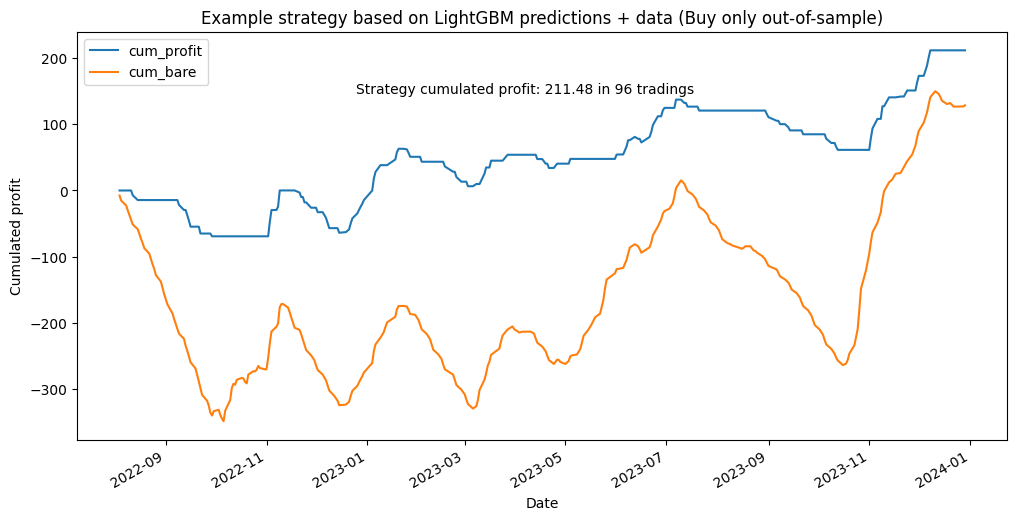

In [40]:
plot_strategy(strategy_df, "LightGBM", "+ data (Buy only out-of-sample)")

In [41]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [42]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [43]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
0,1,-7.580000,0,0.000000,-7.580000
1,1,-15.240000,0,0.000000,-15.240000
2,1,-22.680000,0,0.000000,-22.680000
3,1,-30.190000,0,0.000000,-30.190000
4,1,-37.090000,0,0.000000,-37.090000
...,...,...,...,...,...
279,1,60.050021,0,141.790001,35.260002
282,1,82.840001,0,150.899988,67.829969
285,1,117.249983,0,172.989976,102.239951
288,0,144.989978,1,211.479968,140.729944


In [44]:
compare_df[mask_out].shape

(151, 5)

In [45]:
compare_df.sum(axis=0)

bare_rf_pred_out         221.000000
cum_profit_out        -28858.658230
mmar_rf_pred_out          96.000000
mmar_cum_profit_out    13446.823859
mmar_cum_bare_out     -49180.449390
dtype: float64

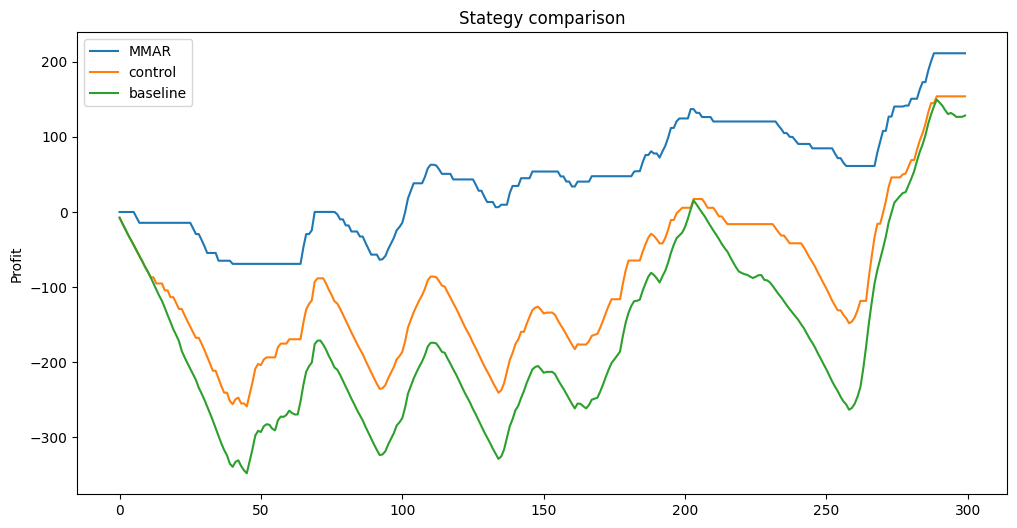

In [47]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()